In [1]:
%matplotlib notebook
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from rdkit import Chem

In [2]:
def get_compounds(path_to_sdf,
                  molecule_constraints=lambda molecule: True,
                  metal_constraints=lambda metal: True,
                  logK_constraints=lambda logK: True):
    result = []
    
    for mol in Chem.SDMolSupplier(path_to_sdf):
        if mol is None: continue
        targets = [prop for prop in mol.GetPropNames() if prop.startswith("logK")]
        comp = {target.split("_")[-1]: float(mol.GetProp(target)) for target in targets}
        result += [(mol, metal, logK) for metal, logK in comp.items() if molecule_constraints(mol) and metal_constraints(metal) and logK_constraints(logK)]
    
    return result

def get_single_logK(path_to_sdf):
    result = []
    
    for mol in Chem.SDMolSupplier(path_to_sdf):
        if mol is None: continue
        result += [float(mol.GetProp("logK"))]
    
    return np.array(result)

def get_all_logK(path_to_sdf):
    
    result = {}    
    
    for mol in Chem.SDMolSupplier(path_to_sdf):
        if mol is None: continue
        targets = [prop for prop in mol.GetPropNames() if prop.startswith("logK_")]
        logK = {target.split("_")[-1]: float(mol.GetProp(target)) for target in targets}
        for metal in logK:
            if metal in result:
                result[metal] += [logK[metal]]
            else:
                result[metal] = [logK[metal]]
    
    return result

In [3]:
all_metals = ["Mg", "Al", "Ca", "Mn", "Fe", "Ni", "Cu", "Zn", "Ag", "Cd", "Pb", "Bi", "La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Th", "U", "Pu", "Am", "Cm", "Bk", "Cf"]

[6.15 6.84 3.96 4.11 1.15]
[6.15 6.84 3.96 4.11 1.15]


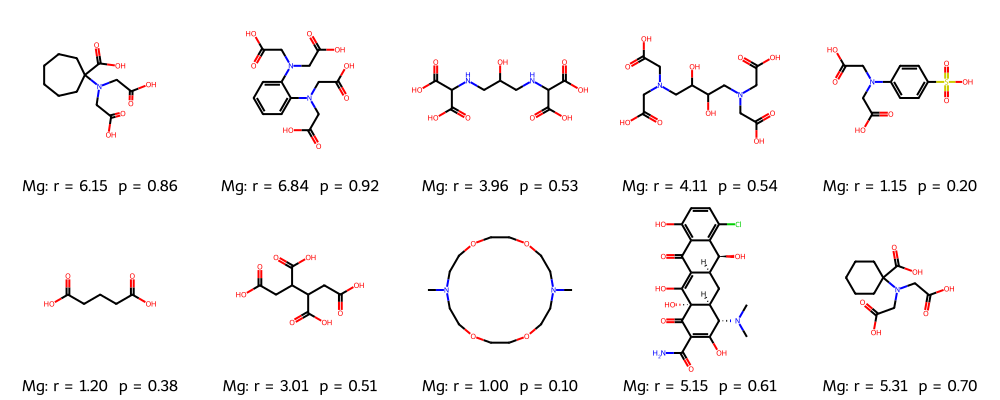

In [60]:
import torch
import random
from rdkit.Chem import Draw
# from mol_featurizer import featurize_sdf_with_metal
def draw_samples(compounds, image_size=200, mols_per_row=5, fmt="{}: r = {:.2f}  p = {:.2f}"):
    if len(compounds) == 0: return
    molecules = [compound[0] for compound in compounds]
    metals = [compound[1] for compound in compounds]
    logKs = [compound[2] for compound in compounds]
    pred_logKs, true_logKs = torch.load(f"../Output/GeneralModel_predictions/{current_metal}_predictions.torch")
    pred_logKs = pred_logKs.squeeze()
    true_logKs = true_logKs.squeeze()
    pred_logKs = true_logKs[np.argsort(true_logKs)][np.argsort(np.argsort(logKs))]
    
    img = Draw.MolsToGridImage(molecules, molsPerRow=mols_per_row, subImgSize=(image_size, image_size),
                               legends=[fmt.format(metal, logK, pred_logK) for metal, logK, pred_logK in zip(metals, logKs, pred_logKs)])
    return img

current_metal = "Mg"
compounds = get_compounds(f"../Data/GeneralModel/{current_metal}_testonly_test.sdf")
pred_logKs = torch.load(f"../Output/GeneralModel_predictions/{current_metal}_predictions.torch")[1].squeeze()
random.Random(42).shuffle(compounds)
sort_logK = np.argsort([c[2] for c in compounds])

print(logK[:5])
print(pred_logKs[np.argsort(pred_logKs)][np.argsort(sort_logK)][:5])
draw_samples(compounds[:10])

In [55]:
import numpy as np
a = np.random.randint(0,10,10)
aa = np.argsort(a)
aaa = np.argsort(aa)

print(a) # original
print(a[np.argsort(a)][np.argsort(np.argsort(a))]) # undone

[6 8 5 3 0 4 4 8 7 3]
[6 8 5 3 0 4 4 8 7 3]


[21:24:16] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:16] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:17] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:17] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:17] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:17] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:17] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:17] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:18] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:18] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:24:18] Warning: molecule is tagged as 3D, but all Z coords are zero


<IPython.core.display.Javascript object>


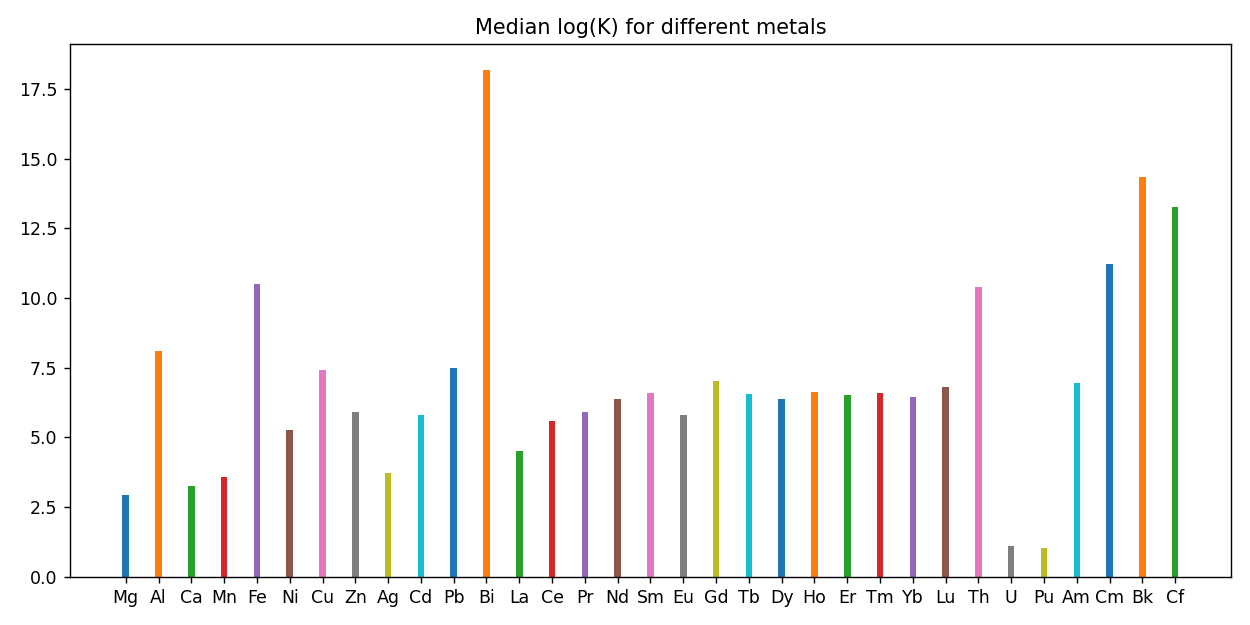

In [8]:
base_path = r"../Data/TransLnAc"

logK = {}

for metal in all_metals:
    path_to_sdf = os.path.join(base_path, f"{metal}_ML.sdf")
    logK[metal] = np.array(get_single_logK(path_to_sdf))
    
width=0.2
labels = list(logK.keys())
x = list(range(len(labels)))

fig, ax = plt.subplots(figsize=(10, 5))

for i, metal in enumerate(logK):
    bar = ax.bar(x[i], np.median(logK[metal]), width, label=metal)
#     ax.plot([x[i]]*len(logK[metal]), logK[metal], ".", markersize=0.5)
#     ax.errorbar(x[i], np.median(logK[metal]), yerr=np.var(logK[metal]))
#     ax.bar_label(bar, padding=3, fmt="%.2lf")

# ax.set_ylabel("mean logK")
ax.set_title("Median log(K) for different metals")
ax.set_xticks(x, labels)
# ax.legend()

fig.tight_layout()
fig.savefig("median logK.png")
plt.show()

<IPython.core.display.Javascript object>


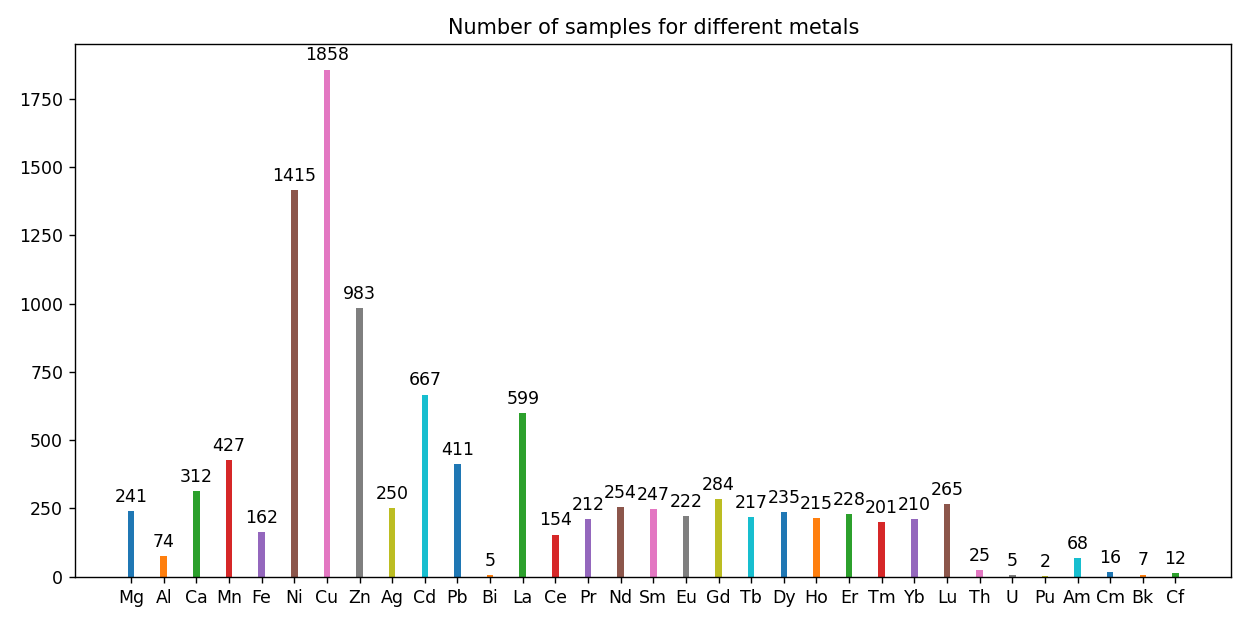

Всего точек: 10483


In [11]:
width=0.2
labels = list(logK.keys())
x = list(range(len(labels)))

fig, ax = plt.subplots(figsize=(10, 5))

total_num = 0
for i, metal in enumerate(logK):
    bar = ax.bar(x[i], len(logK[metal]), width, label=metal)
    ax.bar_label(bar, padding=3, fmt="%.i")
    total_num += len(logK[metal])
print(f"Всего точек: {total_num}")

# ax.set_ylabel("mean logK")
ax.set_title("Number of samples for different metals")
ax.set_xticks(x, labels)
# ax.legend()

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


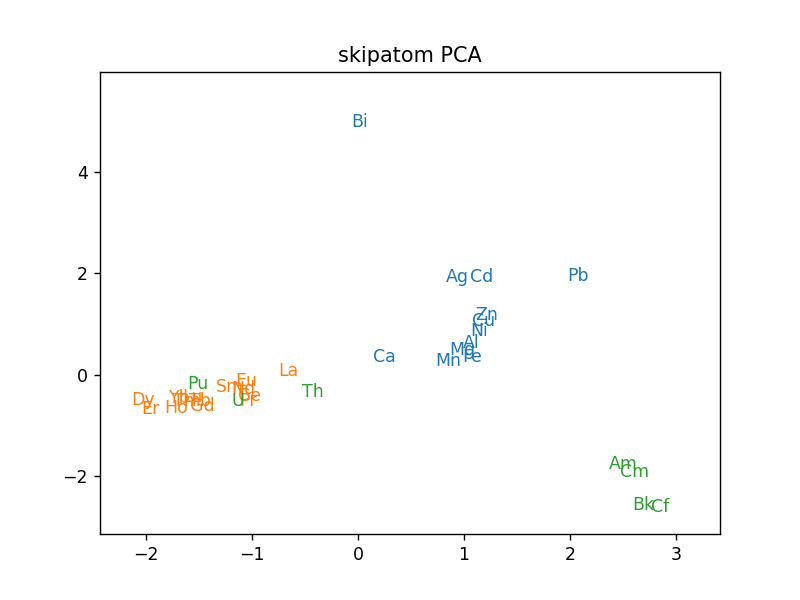

(-3.1515185984610192, 5.977612302955869)

In [15]:
import torch
from sklearn import decomposition

transition_metals = ["Mg", "Al", "Ca", "Mn", "Fe", "Ni", "Cu", "Zn", "Ag", "Cd", "Pb", "Bi"]
Ln_metals = ["La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]
Ac_metals = ["Th", "U", "Pu", "Am", "Cm", "Bk", "Cf"]
all_metals = transition_metals + Ln_metals + Ac_metals

skipatom_features = torch.load("../Data/skipatom_features.torch")
X = torch.tensor([features.squeeze().tolist() for features in skipatom_features.values()])
pca = decomposition.PCA(n_components=2)
coords = pca.fit_transform(X)

# # #

transition_coords = coords[:len(transition_metals)]
Ln_coords = coords[len(transition_metals):len(transition_metals + Ln_metals)]
Ac_coords = coords[len(transition_metals + Ln_metals):len(all_metals)]

fig, ax = plt.subplots()
for xy, labels, color in zip([transition_coords, Ln_coords, Ac_coords], [transition_metals, Ln_metals, Ac_metals], ["C0", "C1", "C2"]):
    for (x, y), label in zip(xy, labels):
        ax.text(x, y, label, ha="center", va="center", color=color)

ax.set_title("skipatom PCA")
x_max, y_max = coords.max(axis=0)
x_min, y_min = coords.min(axis=0)
ax.set_xlim(x_min*1.2, x_max*1.2)
ax.set_ylim(y_min*1.2, y_max*1.2)

[08:58:45] Warning: molecule is tagged as 3D, but all Z coords are zero
[08:58:45] Warning: molecule is tagged as 3D, but all Z coords are zero


<IPython.core.display.Javascript object>


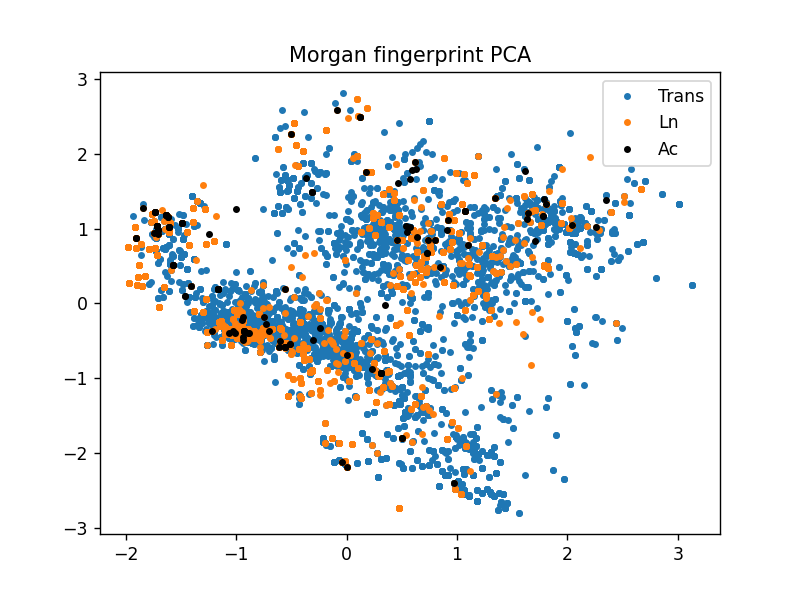

In [20]:
compounds = get_compounds("../Data/TransLnAc.sdf")

transition_mol_fprints = []
Ln_mol_fprints = []
Ac_mol_fprints = []
for mol, metal, logK in compounds:
    mol_fprint = ecfp_molstring(mol, radius=4, size=512)
    if metal in transition_metals:
        transition_mol_fprints += [mol_fprint]
    elif metal in Ln_metals:
        Ln_mol_fprints += [mol_fprint]
    else:
        Ac_mol_fprints += [mol_fprint]

all_fprints = np.array(transition_mol_fprints + Ln_mol_fprints + Ac_mol_fprints)
pca = decomposition.PCA(n_components=2)
coords = pca.fit_transform(all_fprints)

transition_coords = coords[:len(transition_mol_fprints)]
Ln_coords = coords[len(transition_mol_fprints):len(transition_mol_fprints + Ln_mol_fprints)]
Ac_coords = coords[len(transition_mol_fprints + Ln_mol_fprints):]

fig, ax = plt.subplots()
ax.set_title("Morgan fingerprint PCA")
ax.plot(*transition_coords.T, ".", color="C0", label="Trans")
ax.plot(*Ln_coords.T, ".", color="C1", label="Ln")
ax.plot(*Ac_coords.T, ".", color="black", label="Ac")
ax.legend()

## Strong testonly

Для каждого металла берем его датасет и исключаем из остальных все комплексы с тем же лигандом. Тренируем на том, что останется и тестируем на металле. Таким образом, в тест попадают лишь те лиганды, которых модель не видела.

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from skipatom import SkipAtomInducedModel

In [56]:
def mol_in_dataset(mol, dataset):
    for dataset_mol in dataset:
        if mol.HasSubstructMatch(dataset_mol) and dataset_mol.HasSubstructMatch(mol):
            return dataset_mol
    return None

def del_test_ligands(train_molecules, test_molecules):
    return [mol for mol in train_molecules if mol_in_dataset(mol, test_molecules) is None]

def save_to_sdf(molecules, output_path):
    writer = Chem.SDWriter(output_path)
    for molecule in molecules:
        writer.write(molecule)

def merge_metals(datasets, property_name):
    all_molecules = []
    for metal in datasets:
        for molecule in datasets[metal]:
            existing_mol = mol_in_dataset(molecule, all_molecules)
            if existing_mol is None:
                try:
                    logK = molecule.GetProp(property_name)
                except KeyError:
                    raise TypeError(f"\"{property_name}\" not in {list(molecule.GetPropNames())}")
                molecule = copy.deepcopy(molecule)
                molecule.ClearProp(property_name)
                molecule.SetProp(f"logK_{metal}", logK)
                all_molecules += [molecule]
            else:
                try:
                    logK = molecule.GetProp(property_name)
                except KeyError:
                    raise TypeError(f"\"{property_name}\" not in {list(molecule.GetPropNames())}")
                existing_mol.SetProp(f"logK_{metal}", logK)
    return all_molecules

def create_sdf(datasets, train_metals, test_metals, output_path, property_name="LogK"):
    test_molecules = []
    for metal in test_metals:
        test_molecules += datasets[metal]
    
    new_datasets = {metal: del_test_ligands(datasets[metal], test_molecules) for metal in train_metals}
    molecules = merge_metals(new_datasets, property_name)
    
    save_to_sdf(molecules, output_path)
    return new_datasets


transition_metals = ["Mg", "Al", "Ca", "Mn", "Fe", "Ni", "Cu", "Zn", "Ag", "Cd", "Pb", "Bi"]
Ln_metals = ["La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]
Ac_metals = ["Th", "Am", "Cm", "Bk", "Cf"] # "U", "Pu",
all_metals = transition_metals + Ln_metals + Ac_metals

In [58]:
input_path = "../Data/TransLnAc"
datasets = {metal: list(Chem.SDMolSupplier(f"{input_path}/{metal}_ML.sdf")) for metal in all_metals}

[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:23:20] Warning: molecule is tagged as 3D, but all Z coords are zero


In [59]:
mols_per_metal = {}
for metal in all_metals:
    print(f"{metal} is procesed...")
    mols_per_metal[metal] = create_sdf(datasets,
                                     train_metals=[m for m in all_metals if m != metal],
                                     test_metals=[metal],
                                     output_path=f"../Data/StrongTestonly/{metal}_strong_testonly_train.sdf",
                                     property_name="logK")

Mg is procesed...
Al is procesed...
Ca is procesed...
Mn is procesed...
Fe is procesed...
Ni is procesed...
Cu is procesed...
Zn is procesed...
Ag is procesed...
Cd is procesed...
Pb is procesed...
Bi is procesed...
La is procesed...
Ce is procesed...
Pr is procesed...
Nd is procesed...
Sm is procesed...
Eu is procesed...
Gd is procesed...
Tb is procesed...
Dy is procesed...
Ho is procesed...
Er is procesed...
Tm is procesed...
Yb is procesed...
Lu is procesed...
Th is procesed...
Am is procesed...
Cm is procesed...
Bk is procesed...
Cf is procesed...


<IPython.core.display.Javascript object>


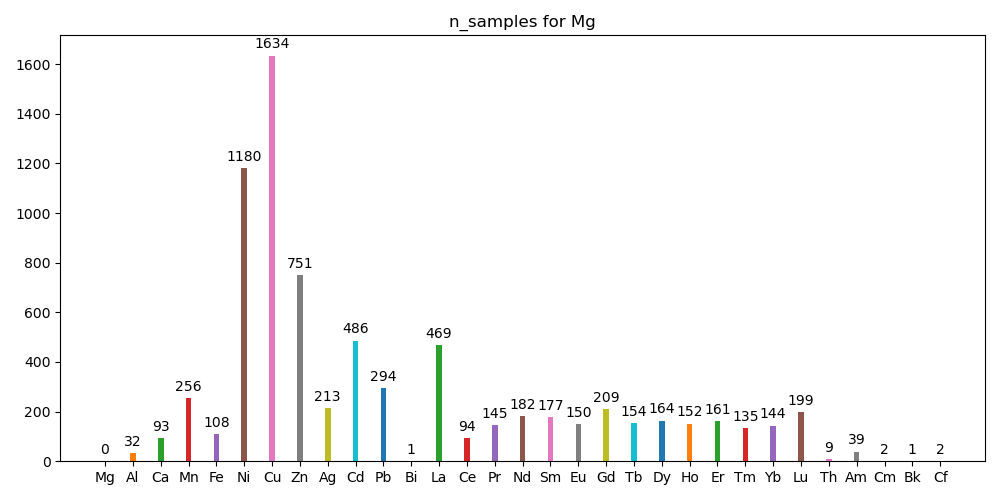

<IPython.core.display.Javascript object>


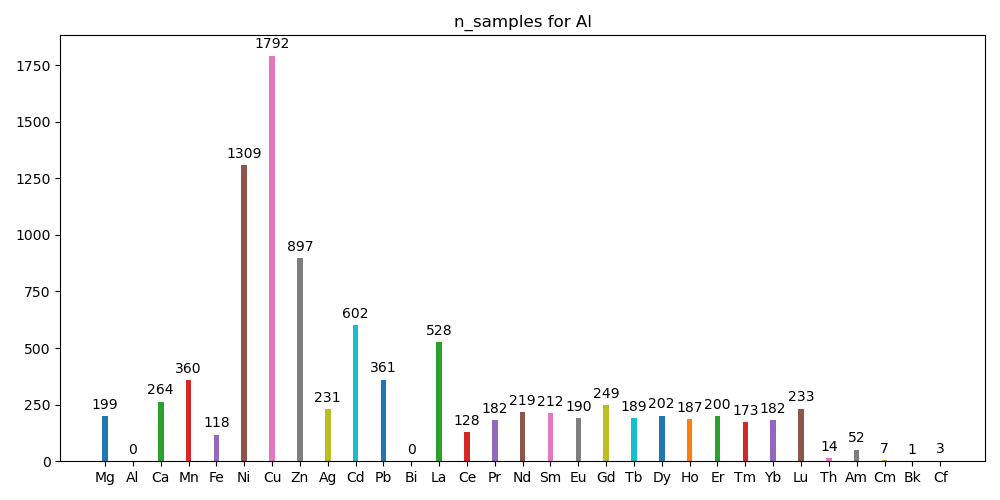

<IPython.core.display.Javascript object>


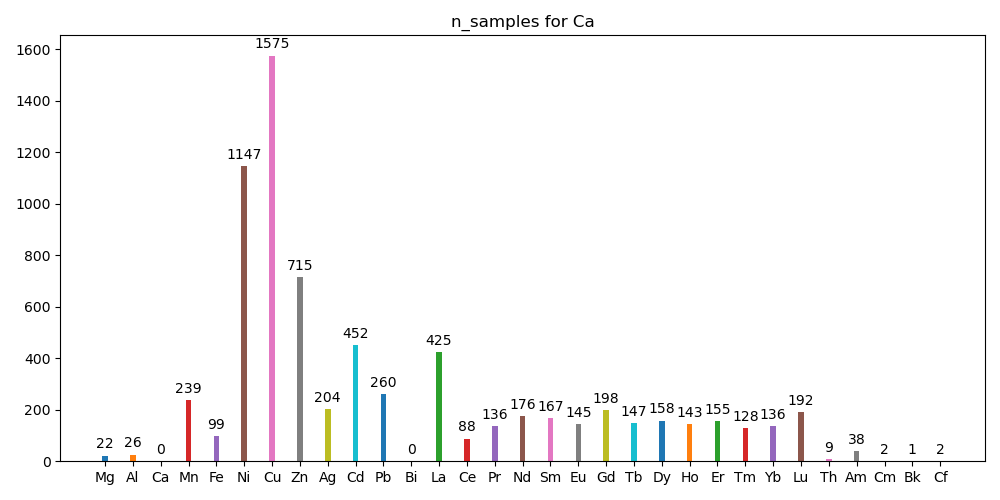

<IPython.core.display.Javascript object>


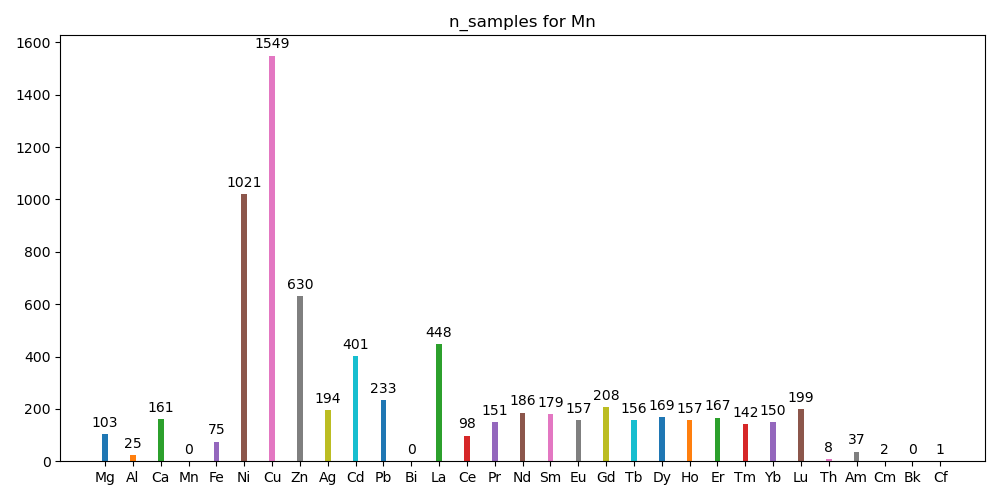

<IPython.core.display.Javascript object>


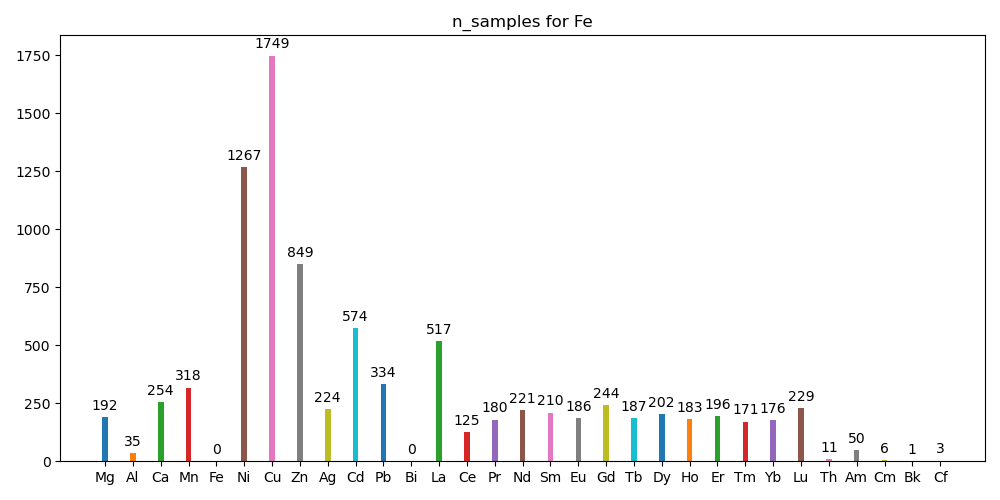

<IPython.core.display.Javascript object>


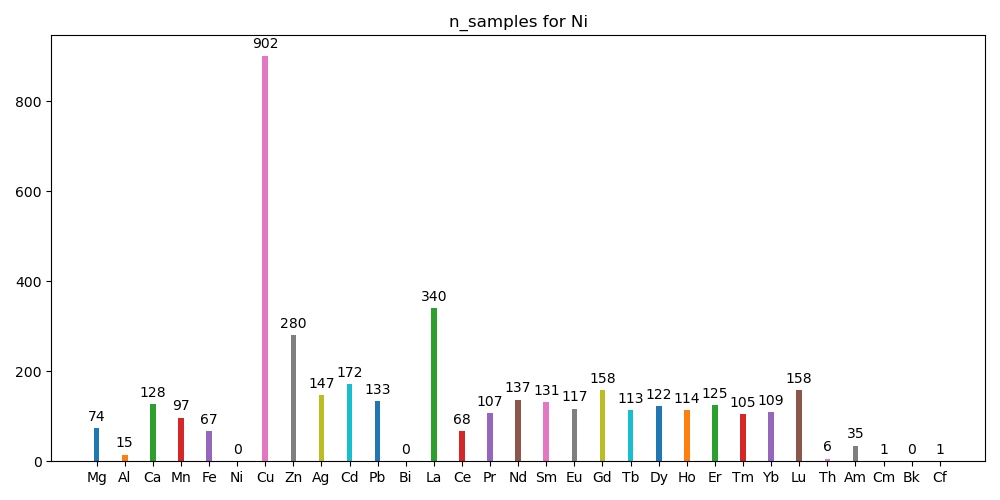

<IPython.core.display.Javascript object>


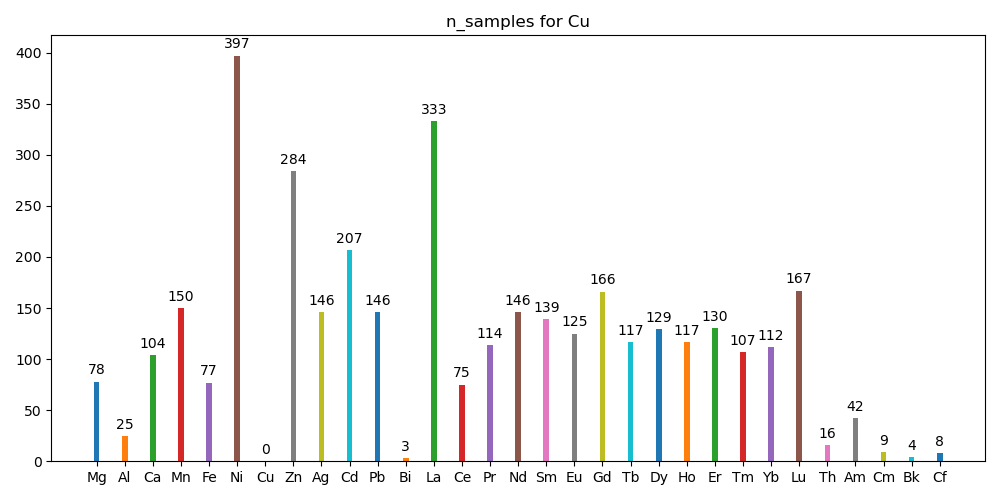

<IPython.core.display.Javascript object>


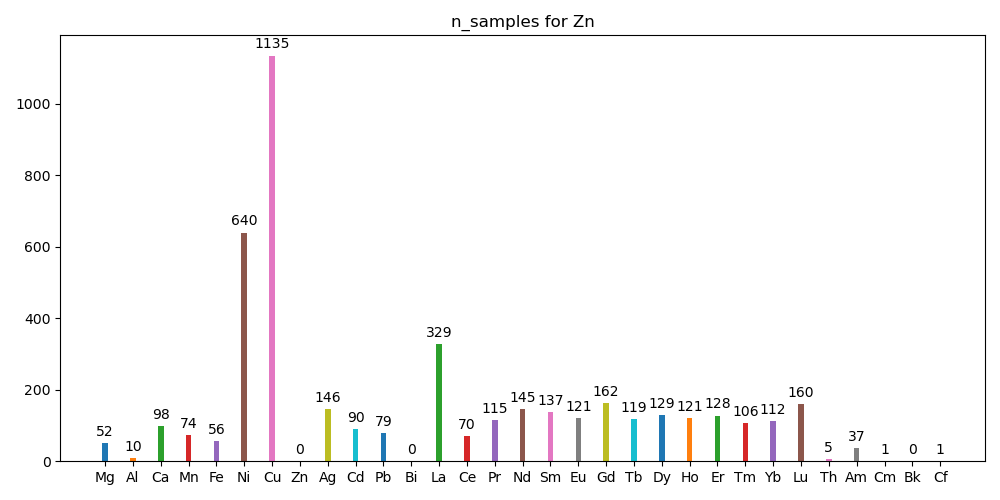

<IPython.core.display.Javascript object>


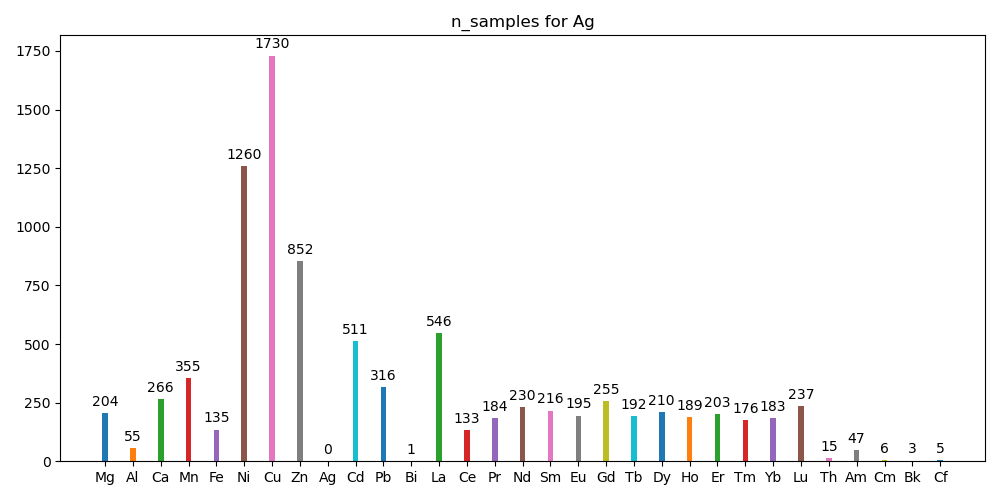

<IPython.core.display.Javascript object>


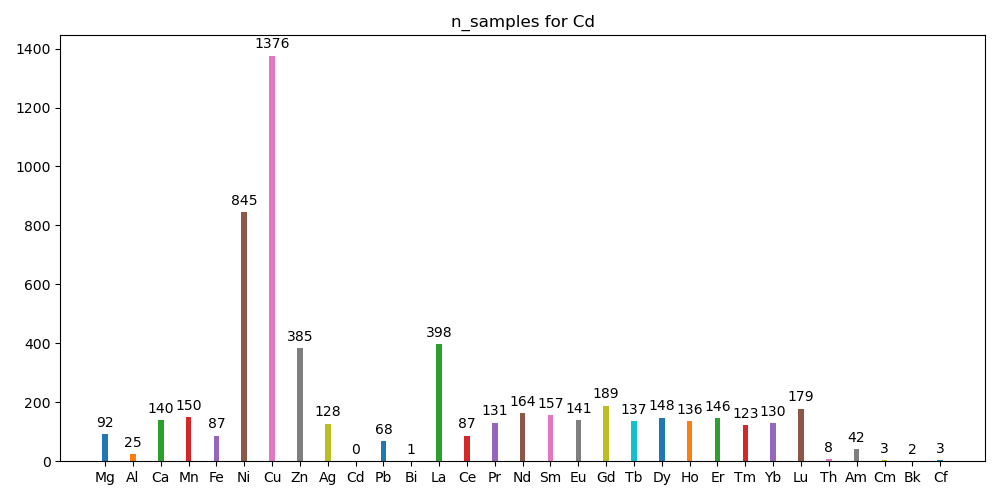

<IPython.core.display.Javascript object>


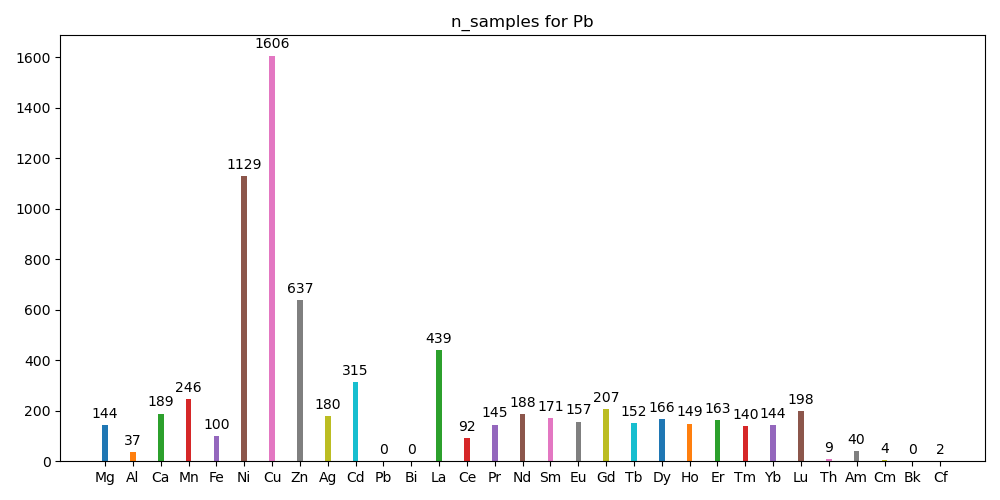

<IPython.core.display.Javascript object>


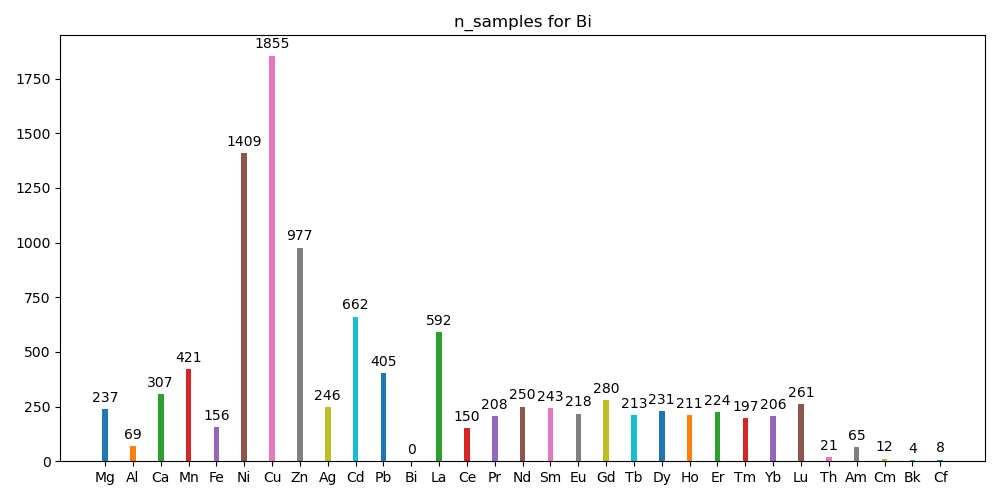

<IPython.core.display.Javascript object>


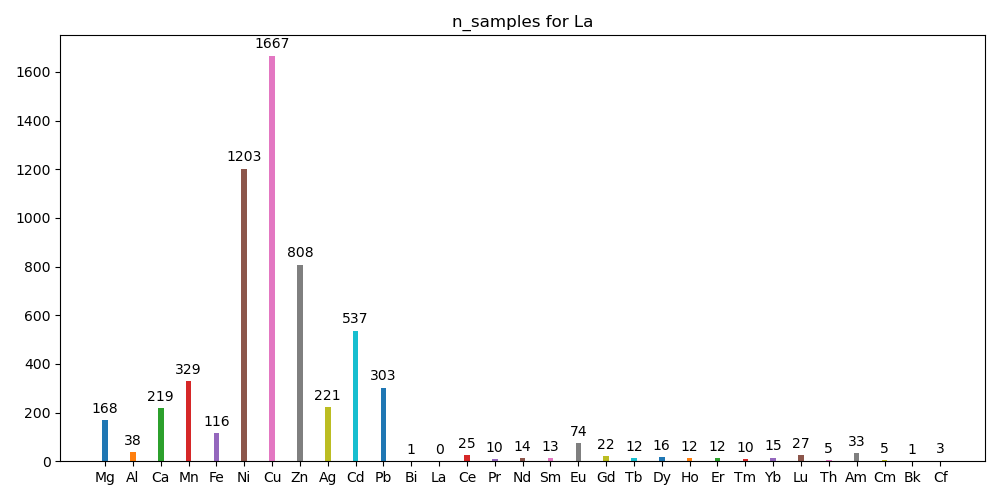

<IPython.core.display.Javascript object>


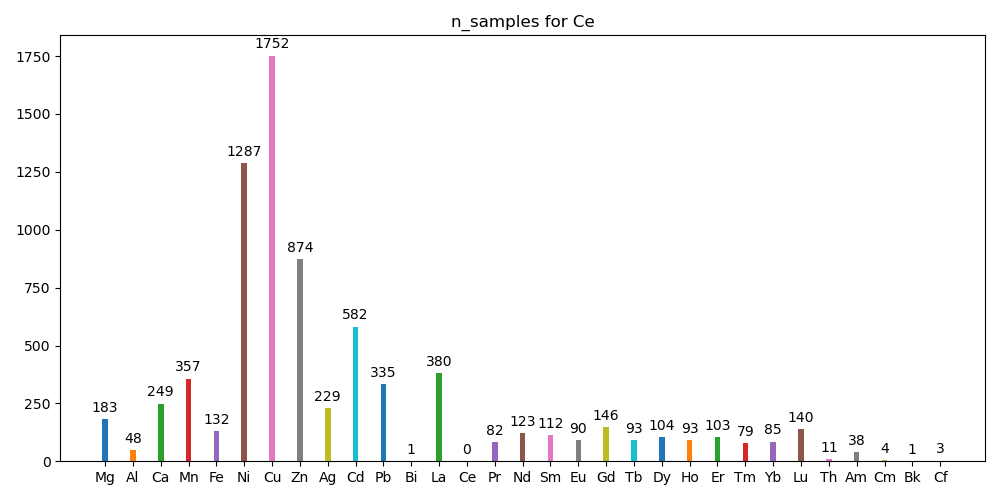

<IPython.core.display.Javascript object>


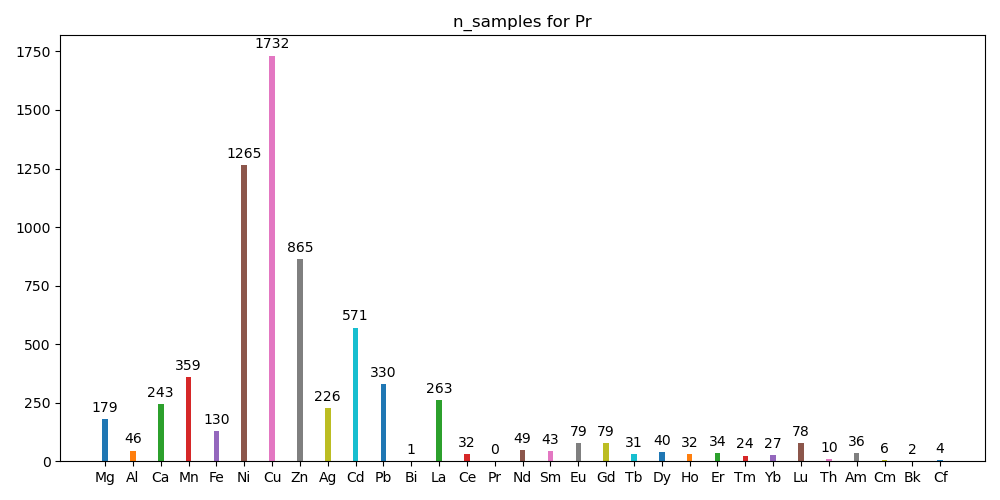

<IPython.core.display.Javascript object>


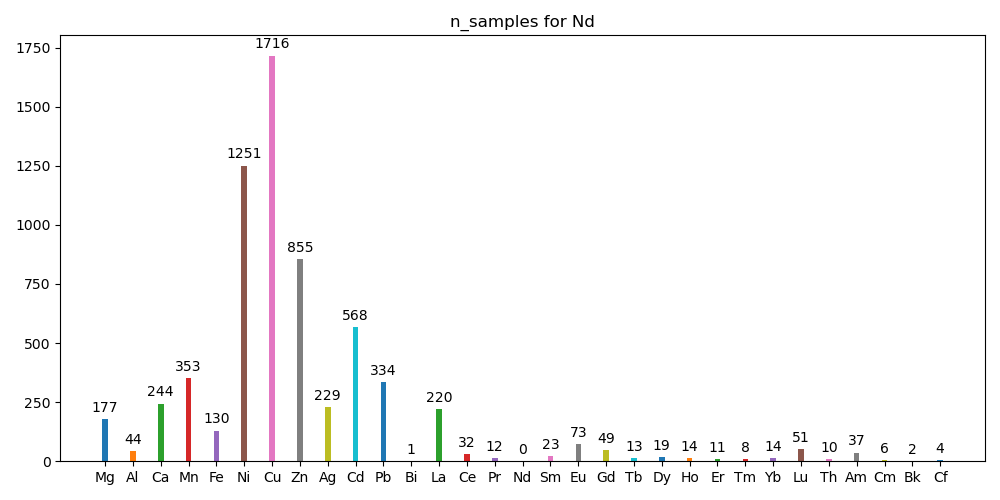

<IPython.core.display.Javascript object>


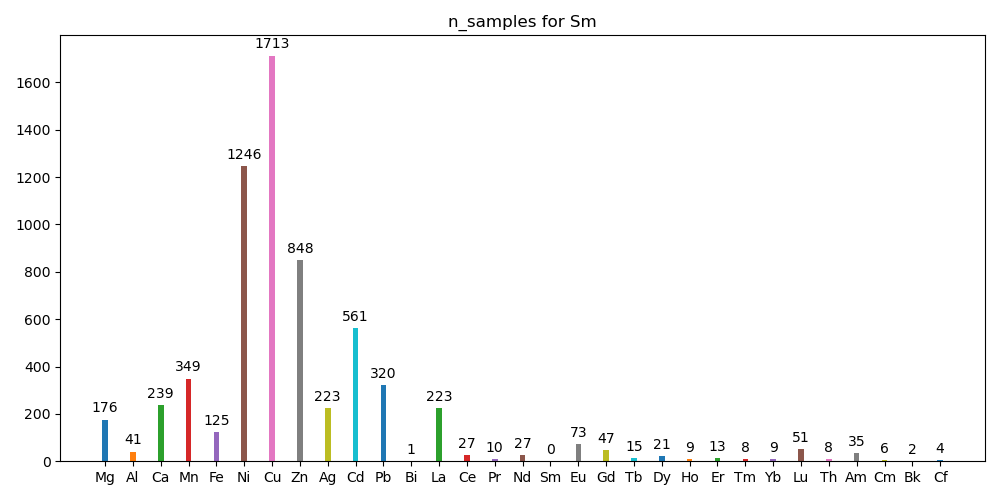

<IPython.core.display.Javascript object>


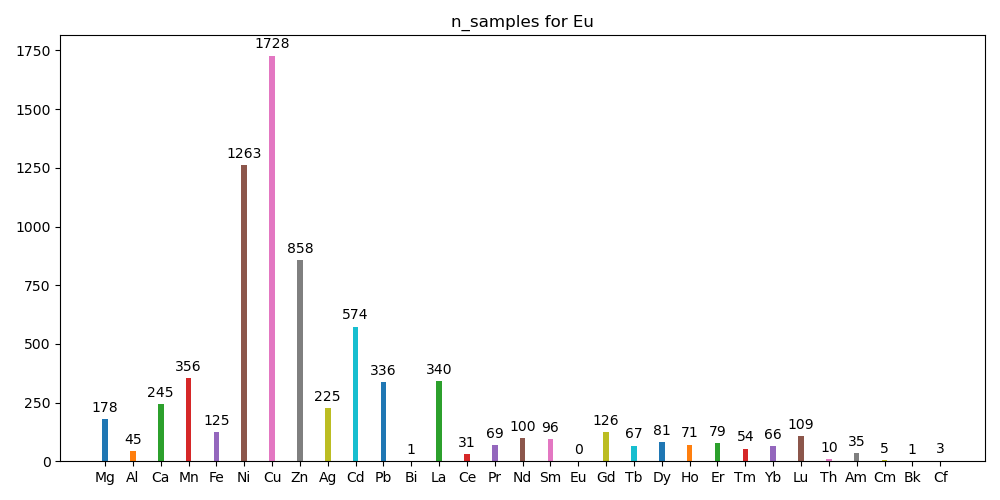

<IPython.core.display.Javascript object>


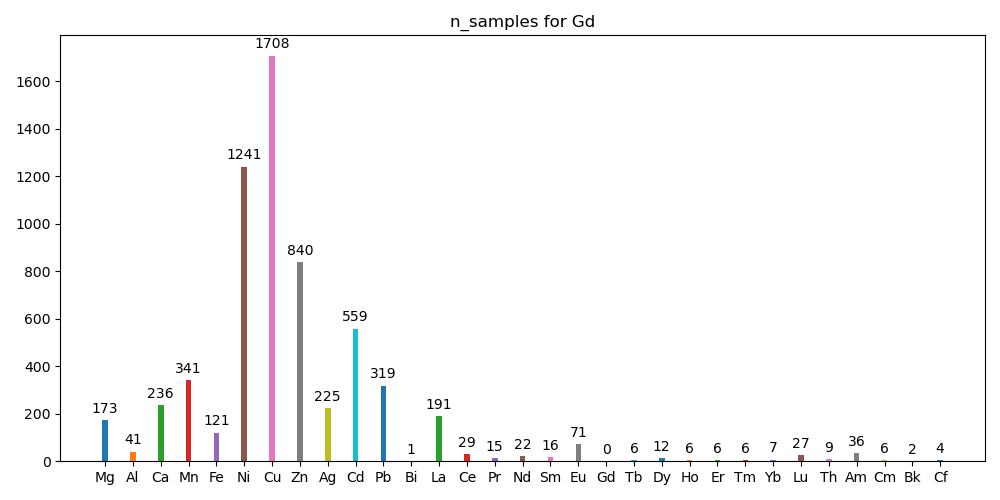

<IPython.core.display.Javascript object>


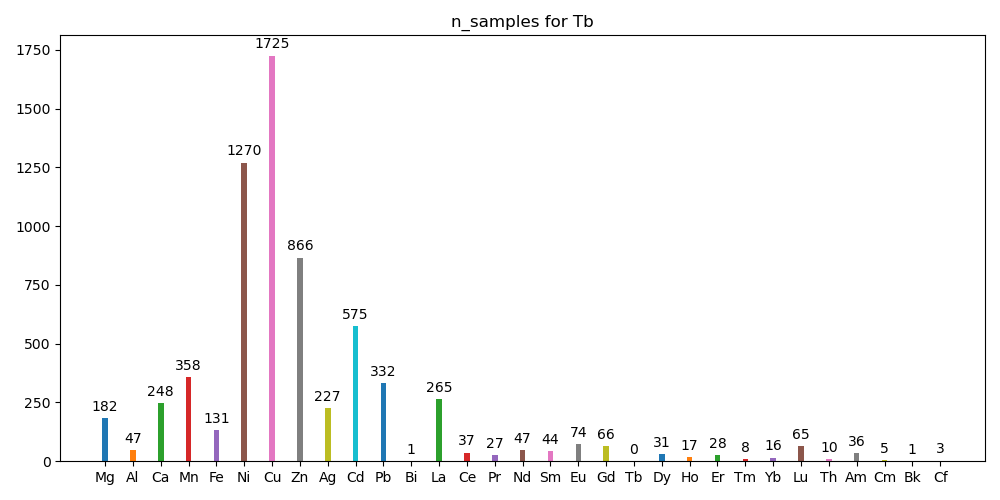

C:\Users\user\AppData\Local\Temp\ipykernel_2384\1202692695.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 5))


<IPython.core.display.Javascript object>


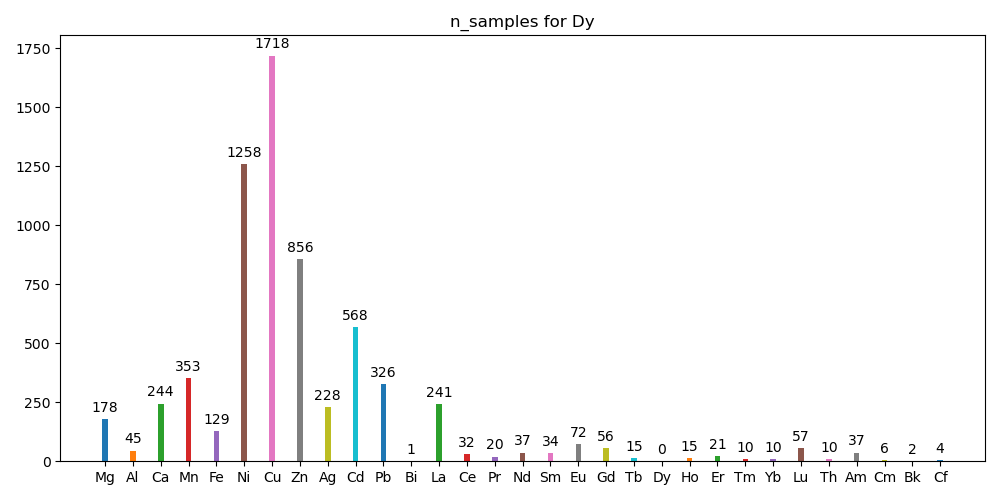

<IPython.core.display.Javascript object>


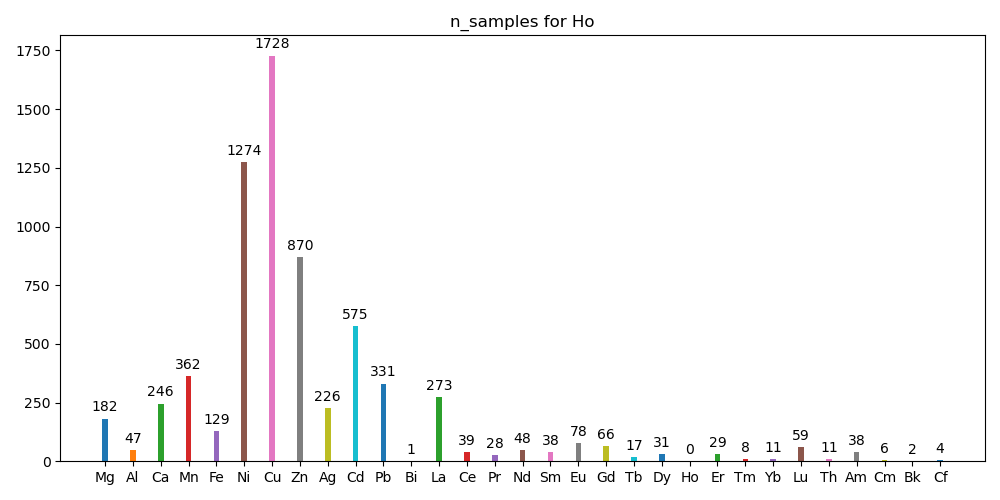

<IPython.core.display.Javascript object>


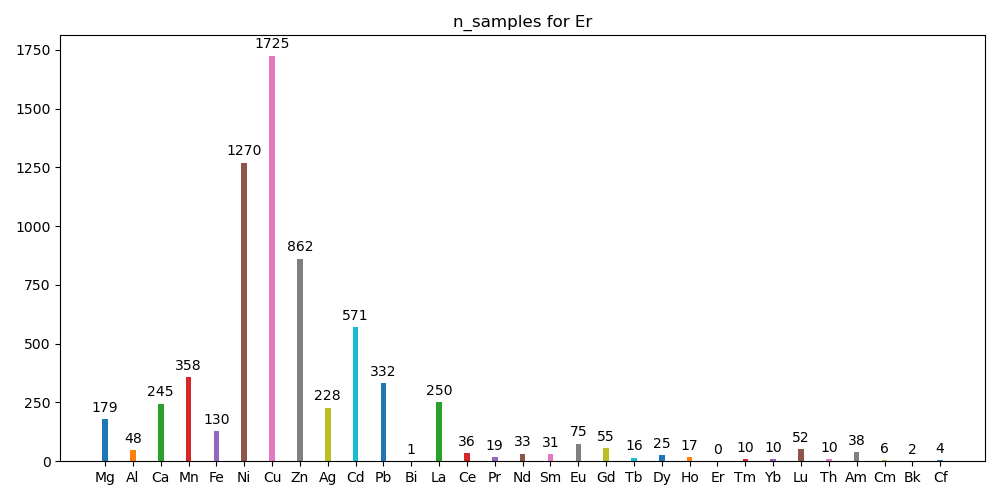

<IPython.core.display.Javascript object>


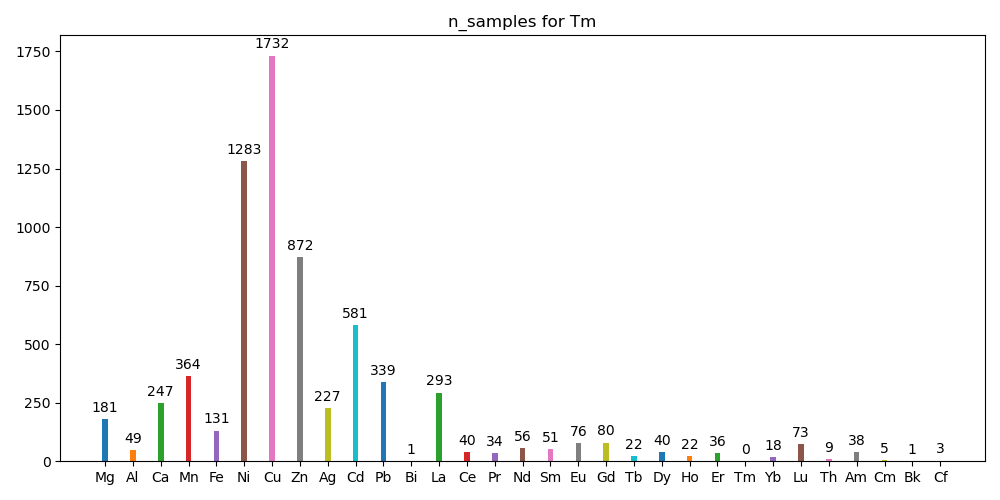

<IPython.core.display.Javascript object>


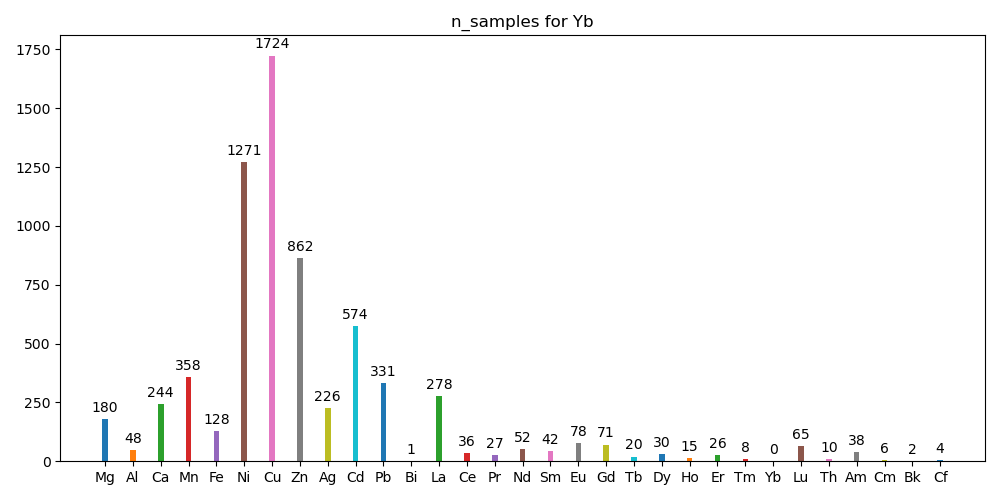

<IPython.core.display.Javascript object>


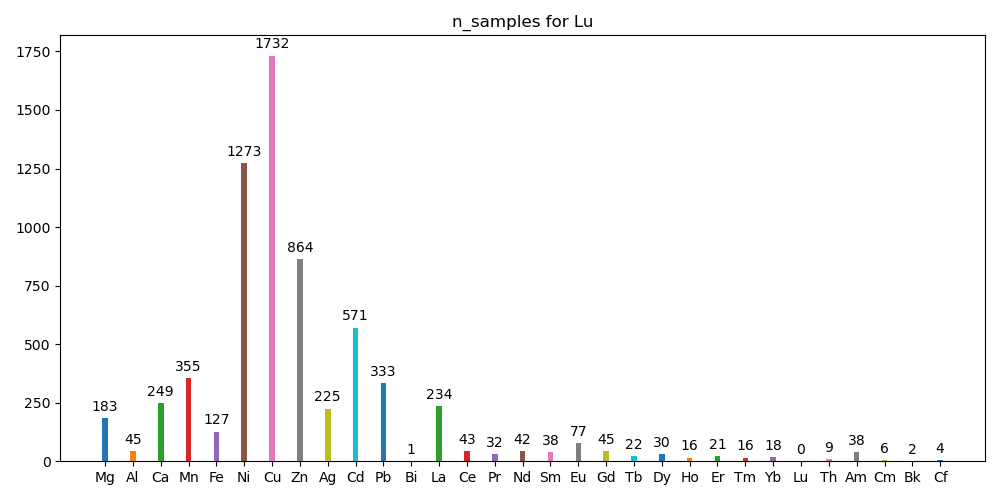

<IPython.core.display.Javascript object>


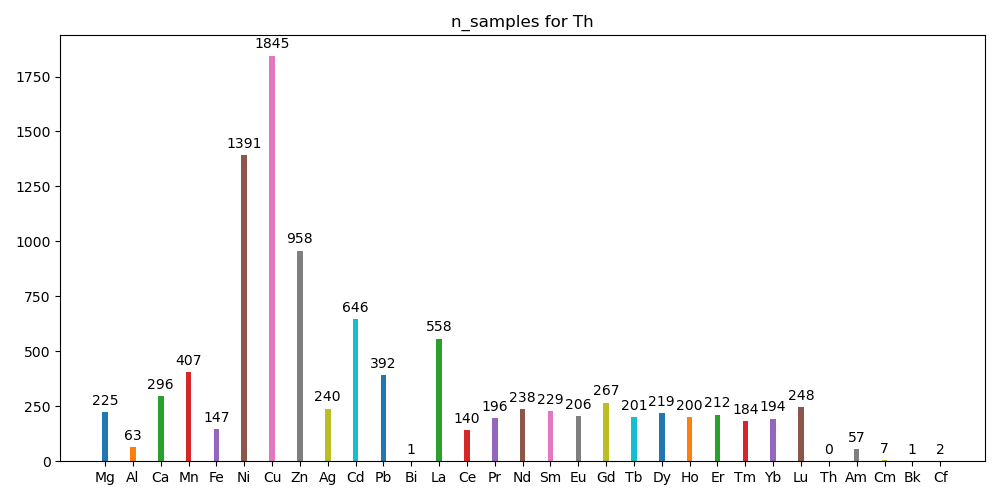

<IPython.core.display.Javascript object>


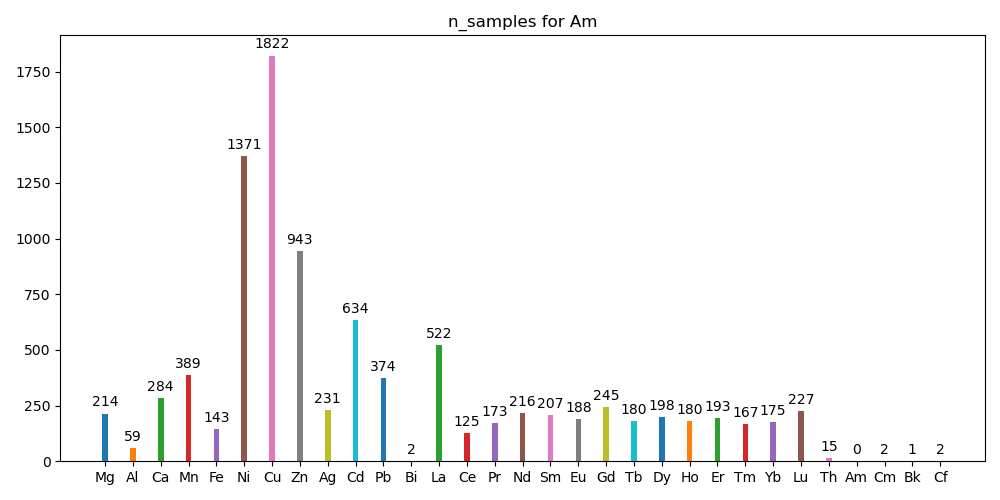

<IPython.core.display.Javascript object>


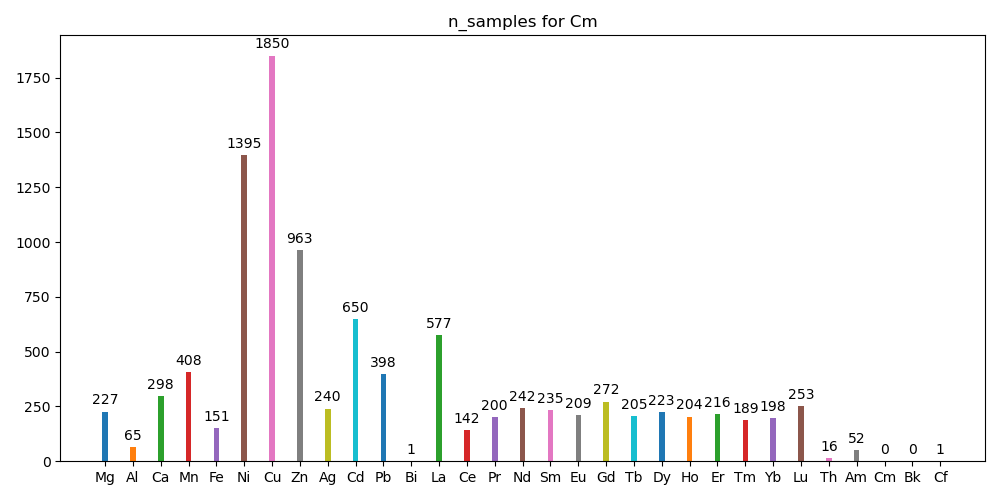

<IPython.core.display.Javascript object>


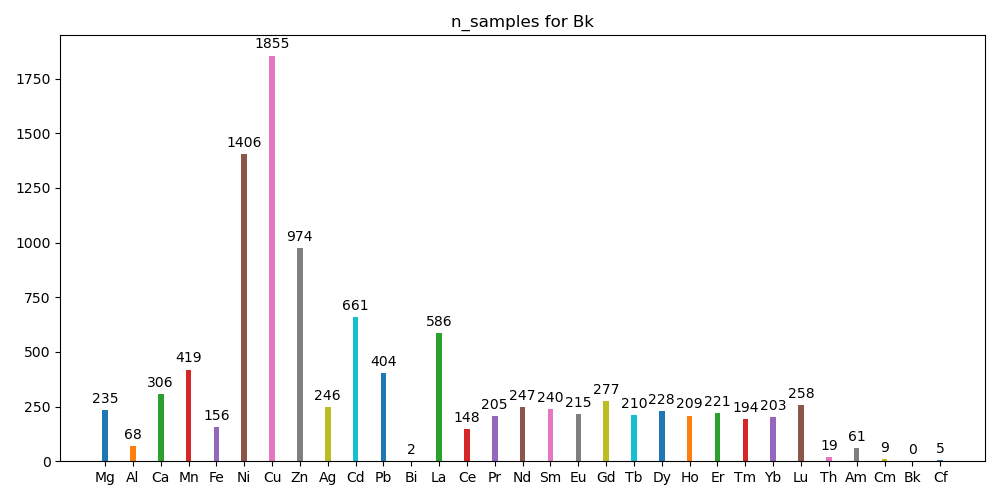

<IPython.core.display.Javascript object>


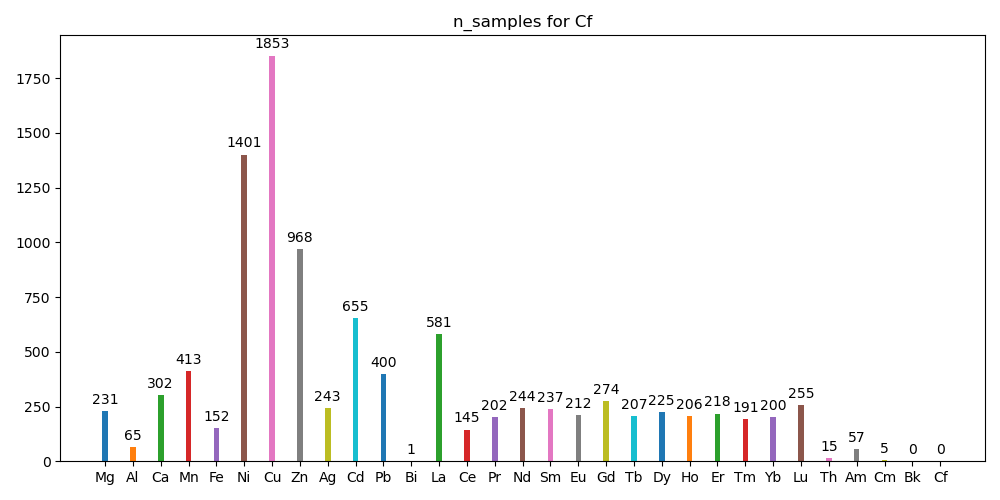

In [62]:
for test_metal in all_metals:
    width=0.2
    x = list(range(len(all_metals)))

    fig, ax = plt.subplots(figsize=(10, 5))

    for i, metal in enumerate(all_metals):
        try:
            bar = ax.bar(x[i], len(mols_per_metal[test_metal][metal]), width, label=metal)
        except KeyError:
            bar = ax.bar(x[i], 0, width, label=metal)
        ax.bar_label(bar, padding=3, fmt="%.i")

    ax.set_title(f"n_samples for {test_metal}")
    ax.set_xticks(x, all_metals)

    fig.tight_layout()
    fig.savefig(f"../Output/StrongTestonlyNSamples/{test_metal}.png")
#     plt.show()

### Data with conditions (temperature, ionic strength, metal charge)

In [4]:
from tqdm.auto import tqdm

base_path = "../Data/OneM_cond"

df = pd.DataFrame({"name": [], "smiles": [], "metal": [], "charge": [], "logK": [], "temperature": [], "ionic_str": []})

for sdf_filename in (pbar := tqdm(os.listdir(base_path))):
    for mol in (mol_pbar := tqdm(Chem.SDMolSupplier(os.path.join(base_path, sdf_filename)), leave=False, desc=sdf_filename)):
        if mol is None: continue
        for target in [prop for prop in mol.GetPropNames() if prop.startswith("logK_")]:
            element_symbol, charge_str, temperature_str, ionic_str_str = target.split("_")[1:]
            charge = float(charge_str.split("=")[-1])
            temperature = float(temperature_str.split("=")[-1])
            ionic_str = float(ionic_str_str.split("=")[-1])
            logK = float(mol.GetProp(target))
        
            new_df = pd.DataFrame({
                "name": [mol.GetProp("Name")],
                "smiles": [Chem.MolToSmiles(mol)],
                "metal": [element_symbol],
                "charge": [charge],
                "logK": [logK],
                "temperature": [temperature],
                "ionic_str": [ionic_str],
            })

            df = pd.concat((df, new_df), ignore_index=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Ac.sdf:   0%|          | 0/7 [00:00<?, ?it/s]

Ag.sdf:   0%|          | 0/502 [00:00<?, ?it/s]

Al.sdf:   0%|          | 0/96 [00:00<?, ?it/s]

Am.sdf:   0%|          | 0/36 [00:00<?, ?it/s]

Au.sdf:   0%|          | 0/2 [00:00<?, ?it/s]

Ba.sdf:   0%|          | 0/217 [00:00<?, ?it/s]

Be.sdf:   0%|          | 0/48 [00:00<?, ?it/s]

Bi.sdf:   0%|          | 0/36 [00:00<?, ?it/s]

Bk.sdf:   0%|          | 0/14 [00:00<?, ?it/s]

Ca.sdf:   0%|          | 0/399 [00:00<?, ?it/s]

Cd.sdf:   0%|          | 0/570 [00:00<?, ?it/s]

Ce.sdf:   0%|          | 0/113 [00:00<?, ?it/s]

Cf.sdf:   0%|          | 0/21 [00:00<?, ?it/s]

Cm.sdf:   0%|          | 0/26 [00:00<?, ?it/s]

Co.sdf:   0%|          | 0/904 [00:00<?, ?it/s]

Cr.sdf:   0%|          | 0/41 [00:00<?, ?it/s]

Cs.sdf:   0%|          | 0/32 [00:00<?, ?it/s]

Cu.sdf:   0%|          | 0/1799 [00:00<?, ?it/s]

Dy.sdf:   0%|          | 0/142 [00:00<?, ?it/s]

Er.sdf:   0%|          | 0/150 [00:00<?, ?it/s]

Eu.sdf:   0%|          | 0/157 [00:00<?, ?it/s]

Fe.sdf:   0%|          | 0/497 [00:00<?, ?it/s]

Ga.sdf:   0%|          | 0/67 [00:00<?, ?it/s]

Gd.sdf:   0%|          | 0/159 [00:00<?, ?it/s]

Hf.sdf:   0%|          | 0/10 [00:00<?, ?it/s]

Hg.sdf:   0%|          | 0/190 [00:00<?, ?it/s]

Ho.sdf:   0%|          | 0/137 [00:00<?, ?it/s]

In.sdf:   0%|          | 0/55 [00:00<?, ?it/s]

K.sdf:   0%|          | 0/87 [00:00<?, ?it/s]

La.sdf:   0%|          | 0/253 [00:00<?, ?it/s]

Li.sdf:   0%|          | 0/64 [00:00<?, ?it/s]

Lu.sdf:   0%|          | 0/135 [00:00<?, ?it/s]

Mg.sdf:   0%|          | 0/305 [00:00<?, ?it/s]

Mn.sdf:   0%|          | 0/420 [00:00<?, ?it/s]

Mo.sdf:   0%|          | 0/1 [00:00<?, ?it/s]

Na.sdf:   0%|          | 0/85 [00:00<?, ?it/s]

Nd.sdf:   0%|          | 0/147 [00:00<?, ?it/s]

Ni.sdf:   0%|          | 0/1262 [00:00<?, ?it/s]

Np.sdf:   0%|          | 0/13 [00:00<?, ?it/s]

Pa.sdf:   0%|          | 0/1 [00:00<?, ?it/s]

Pb.sdf:   0%|          | 0/322 [00:00<?, ?it/s]

Pd.sdf:   0%|          | 0/46 [00:00<?, ?it/s]

Pm.sdf:   0%|          | 0/10 [00:00<?, ?it/s]

Pr.sdf:   0%|          | 0/139 [00:00<?, ?it/s]

Pt.sdf:   0%|          | 0/4 [00:00<?, ?it/s]

Pu.sdf:   0%|          | 0/18 [00:00<?, ?it/s]

Rb.sdf:   0%|          | 0/29 [00:00<?, ?it/s]

Re.sdf:   0%|          | 0/1 [00:00<?, ?it/s]

Rh.sdf:   0%|          | 0/1 [00:00<?, ?it/s]

Sb.sdf:   0%|          | 0/2 [00:00<?, ?it/s]

Sc.sdf:   0%|          | 0/32 [00:00<?, ?it/s]

Sm.sdf:   0%|          | 0/156 [00:00<?, ?it/s]

Sn.sdf:   0%|          | 0/21 [00:00<?, ?it/s]

Sr.sdf:   0%|          | 0/225 [00:00<?, ?it/s]

Tb.sdf:   0%|          | 0/139 [00:00<?, ?it/s]

Th.sdf:   0%|          | 0/61 [00:00<?, ?it/s]

Ti.sdf:   0%|          | 0/5 [00:00<?, ?it/s]

Tl.sdf:   0%|          | 0/69 [00:00<?, ?it/s]

Tm.sdf:   0%|          | 0/137 [00:00<?, ?it/s]

U.sdf:   0%|          | 0/13 [00:00<?, ?it/s]

V.sdf:   0%|          | 0/10 [00:00<?, ?it/s]

Y.sdf:   0%|          | 0/193 [00:00<?, ?it/s]

Yb.sdf:   0%|          | 0/141 [00:00<?, ?it/s]

Zn.sdf:   0%|          | 0/784 [00:00<?, ?it/s]

Zr.sdf:   0%|          | 0/14 [00:00<?, ?it/s]

In [5]:
df

,name,smiles,metal,charge,logK,temperature,ionic_str
0,Ethanedioic_acid_(Oxalic_acid),O=C(O)C(=O)O,Ac,3.0,4.36,25.0,0.1
1,Ethanedioic_acid_(Oxalic_acid),O=C(O)C(=O)O,Ac,3.0,3.56,25.0,1.0
2,Dihydroxycyclobutenedione_(Squaric_acid),O=c1c(O)c(O)c1=O,Ac,3.0,1.85,25.0,1.0
3,Hydrogen_thiocyanate_(Thiocyanic_acid),N#CS,Ac,3.0,0.05,25.0,1.0
4,Nitrate_ion,O=[N+]([O-])[O-],Ac,3.0,0.10,25.0,1.0
...,...,...,...,...,...,...,...
15047,Hydrogen_fluoride_(Hydrofluoric_acid),F,Zr,4.0,9.44,25.0,4.0
15048,Hydrogen_fluoride_(Hydrofluoric_acid),F,Zr,4.0,9.80,25.0,0.0
15049,Chloride_ion,[Cl-],Zr,4.0,0.30,25.0,2.0
15050,Chloride_ion,[Cl-],Zr,4.0,0.92,20.0,6.5


In [7]:
logK = {}
for i in df.index:
    M = df['metal'][i]
    charge = int(df['charge'][i])
    if len(df[df["metal"]==M]["charge"].unique()) > 1:
        metal = f"${M}^{{+{charge}}}$"
    else:
        metal = f"${M}$"
    if metal in logK:
        logK[metal] += 1
    else:
        logK[metal] = 1

В исходной skipatom-модели не хватает следующих металлов:
* Am - дообучили
* Bk - дообучили
* Cf - дообучили
* Cm - дообучили
* Ra - дообучили
* Es - нет данных в https://www.crystallography.net/cod/
* Fm - нет данных в https://www.crystallography.net/cod/
* Md - нет данных в https://www.crystallography.net/cod/

в общем, убираем Es, Fm и Md из рассмотрения

In [9]:
metals = df["metal"].unique()
atomic_num = np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals])
metals[np.argsort(atomic_num)]

array(['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr',
       'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr',
       'Mo', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs', 'Ba', 'La',
       'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
       'Tm', 'Yb', 'Lu', 'Hf', 'Re', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi',
       'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf'],
      dtype=object)

<IPython.core.display.Javascript object>


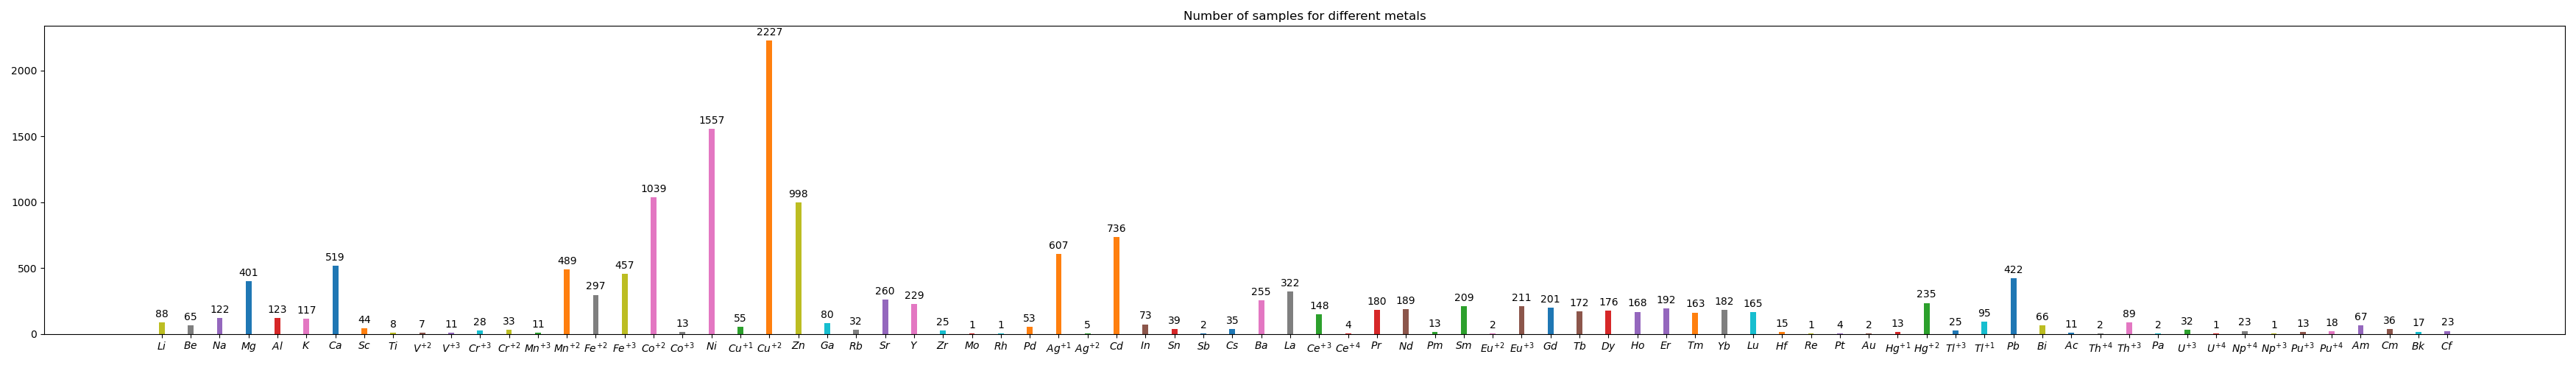

In [19]:
width=0.2
labels = list(logK.keys())

atomic_numbers = [Chem.Atom(metal).GetAtomicNum() for metal in df["metal"].unique() for i in range(len(df[df["metal"]==metal]["charge"].unique()))]
x = np.arange(len(atomic_numbers))[np.argsort(np.argsort(atomic_numbers))]

fig, ax = plt.subplots(figsize=(35, 5))

for i, metal in enumerate(logK):
    bar = ax.bar(x[i], logK[metal], width, label=metal)
    ax.bar_label(bar, padding=3, fmt="%.i")

ax.set_title("Number of samples for different metals")
ax.set_xticks(x, labels, fontsize=10)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


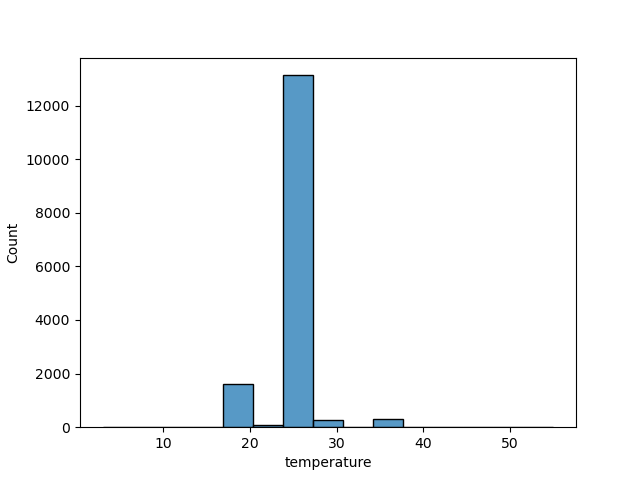

<AxesSubplot:xlabel='temperature', ylabel='Count'>

In [12]:
plt.subplots()
sns.histplot(data=df, x="temperature")

<IPython.core.display.Javascript object>


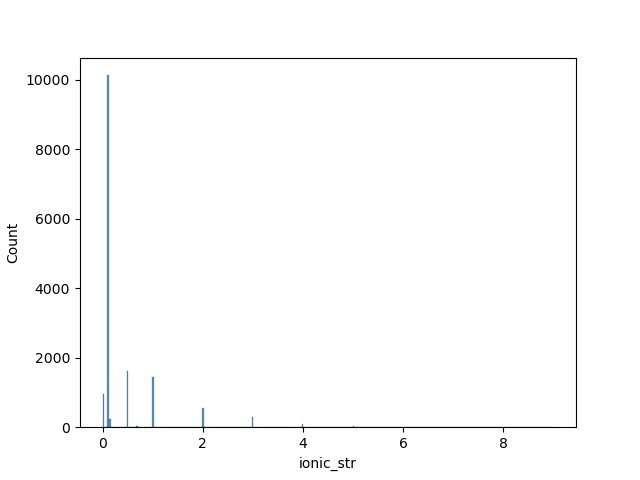

<AxesSubplot:xlabel='ionic_str', ylabel='Count'>

In [14]:
plt.subplots()
sns.histplot(data=df, x="ionic_str")